# Week 10. Big data
## Today's objectives

1. Understand some of the strategies to handle large data sets
2. Know how to profile the performance of particular functions
3. Know what parallelization does and how to implement it

Big data is often characterized by the 3 "Vs": velocity, volume, and variety.

We've talked implicitly about the "variety" throughout the course — how to clean, join, and otherwise wrangle datasets. Here, we'll focus on issues of volume. In short, what can you do when a dataset doesn't fit into memory, or your code takes too long to run.

Here, I'll set out a hierarchy of approaches to dealing with large datasets. Start with the simplest, and move on to the next group of solutions as needed.

## 1. No special coding needed
* Testing and scaling up
* Running overnight
* Finding a secondary computer
* Profiling
* Being economical with data types
* Sampling
* Tiling

This group of strategies is all about being efficient and thoughtful with your analysis. It doesn't need any special procedures or coding, and some of the strategies are self explanatory.

*Testing and scaling up*: get your code working on a tiny subset of the data, before running it on your full dataset. This seems obvious, but will save you a lot of time. For example: run your code on Ventura County data before doing LA County, or take a small city in the county.

*Running overnight*: Again, this seems obvious. But remember: your time is much more valuable than the computer's. You could spend the time to make your code more efficient, or you could just leave your computer running in the kitchen or in a closet while you sleep / go to the beach / do something fun.

*Finding a secondary computer*: Maybe you have an old laptop with a cracked screen, an erratic keyboard, and a battery that holds about 15 minutes of charge? This is the perfect machine to do some web scraping or similar tasks in the background. Leave it running for a few days/weeks/months and plug in an external hard drive. 

*Profiling*: This means identifying the slowest parts of your code, and thinking about how to speed it up. Sometimes, that will be obvious. But in other cases, you can use the `%timeit` function. 

For example, imagine you have a long text document and you want to identify stopwords. You might want to loop over each row of the `DatFrame` using `iterrows()`. Let's try this.

In [65]:
%config Completer.use_jedi = False

# this is a word list. See https://stackoverflow.com/questions/18834636/random-word-generator-python
import requests
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
wordDf = pd.DataFrame(response.content.splitlines(), columns=['word'])
wordDf['is_stopword'] = None
print(len(wordDf))
wordDf.head()

10000


,word,is_stopword
0,b'a',None
1,b'aa',None
2,b'aaa',None
3,b'aaron',None
4,b'ab',None


In [66]:
from nltk.corpus import stopwords

def exclude_stopwords(wdf):
    for idx, row in wdf.iterrows():
        if row['word'] in stopwords.words('english'):
            wdf.loc[idx, 'is_stopword'] = True
        else:
            wdf.loc[idx, 'is_stopword'] = True
    return wdf
           
# to use %timeit, just put it in front of your function
%timeit newdf = exclude_stopwords(wordDf)

2.7 s ± 7.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That took nearly 3 seconds on my computer...not a big deal, but it might matter if you are dealing with tens of thousands of long documents.

What about using `apply` with a `lambda` function? For me, it takes 1 second - a speed up of nearly 3 times.

In [67]:
%timeit wordDf['is_stopword'] = wordDf.word.apply(lambda x: x in stopwords.words('english'))

1 s ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*Being economical with data types*. 

Data types refer to how an object (integer, string, etc.) is stored by Python. `pandas` generally uses the underlying `numpy` data types, [which are described here](https://numpy.org/doc/stable/user/basics.types.html).

Why should you care about data types? Often, it doesn't matter - if you have integers, storing them as a float will usually work just as well. But we've seen several instances where we need to convert the data type.

In particular, numbers can be stored as strings, but we need to convert them to integers or floats to do arithmetic.

And census geoidentifiers (e.g. tract) can be stored as numbers, but that loses the leading zero, so they are hard to join if one table has the geoid as a string.

In [68]:
x = '1'
y = '2'
print(x*y)  # fails because they are strings

TypeError: can't multiply sequence by non-int of type 'str'

In [69]:
print(int(x)*int(y))   # converting to integer works

2


The other major time when you have to worry about data types is to increase the efficiency of your data storage. In general, the order from most- to least-efficient is:
* boolean (True or False)
* integer
* float
* string / object

The relevant consideration is how many *bytes* they consume. For example, an integer can be represented in various ways:
* `int64` is the default, which can represent integers from  from -9223372036854775808 to +9223372036854775807 
* `int32` consumes half as much space, but can only represent -2147483648 to +2147483647
* `int16` and `int8` are also possibilities, if you are sure that you won't have large numbers
* You can also have unsigned integers (positive numbers only)

Similar logic applies to floats: `float64`, `float32`, etc. Here, it's the precision rather than the range that's affected.

In [70]:
import pandas as pd
import numpy as np

# create a dataframe with one column of ones
df = pd.DataFrame(np.ones(50000), columns=['ones'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ones    50000 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


In [71]:
df['ones'] = df.ones.astype('int8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ones    50000 non-null  int8 
dtypes: int8(1)
memory usage: 49.0 KB


We reduce the size of our dataframe from 391k to 49k – an eightfold reduction (which makes sense as we are going from 64 bit to 8 bit).

Here's a less trivial example, using the parcels dataset that we used for ADU prediction.

In [72]:
# you may need to adjust your path
df = pd.read_csv('../weeks7-8/c037_g20_sov_data_by_g20_srprec.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4313 entries, 0 to 4312
Data columns (total 73 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   county    4313 non-null   int64 
 1   srprec    4313 non-null   object
 2   addist    4313 non-null   int64 
 3   cddist    4313 non-null   int64 
 4   sddist    4313 non-null   int64 
 5   bedist    4313 non-null   int64 
 6   TOTREG    4313 non-null   int64 
 7   DEMREG    4313 non-null   int64 
 8   REPREG    4313 non-null   int64 
 9   AIPREG    4313 non-null   int64 
 10  GRNREG    4313 non-null   int64 
 11  LIBREG    4313 non-null   int64 
 12  NLPREG    4313 non-null   int64 
 13  REFREG    4313 non-null   int64 
 14  DCLREG    4313 non-null   int64 
 15  MSCREG    4313 non-null   int64 
 16  TOTVOTE   4313 non-null   int64 
 17  DEMVOTE   4313 non-null   int64 
 18  REPVOTE   4313 non-null   int64 
 19  AIPVOTE   4313 non-null   int64 
 20  GRNVOTE   4313 non-null   int64 
 21  LIBVOTE   4313

Let's look at the maximum number of votes per precinct, to see what data type might be appropriate.

In [73]:
# drop the non-numeric column, get the max of all other columsn, and then get the max of the max
df.drop(columns=['srprec']).max().max()

5709853

That won't fit into `int16` (-32767 to +32767), but we could use `int32`.

In [74]:
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = df[col].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4313 entries, 0 to 4312
Data columns (total 73 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   county    4313 non-null   int32 
 1   srprec    4313 non-null   object
 2   addist    4313 non-null   int32 
 3   cddist    4313 non-null   int32 
 4   sddist    4313 non-null   int32 
 5   bedist    4313 non-null   int32 
 6   TOTREG    4313 non-null   int32 
 7   DEMREG    4313 non-null   int32 
 8   REPREG    4313 non-null   int32 
 9   AIPREG    4313 non-null   int32 
 10  GRNREG    4313 non-null   int32 
 11  LIBREG    4313 non-null   int32 
 12  NLPREG    4313 non-null   int32 
 13  REFREG    4313 non-null   int32 
 14  DCLREG    4313 non-null   int32 
 15  MSCREG    4313 non-null   int32 
 16  TOTVOTE   4313 non-null   int32 
 17  DEMVOTE   4313 non-null   int32 
 18  REPVOTE   4313 non-null   int32 
 19  AIPVOTE   4313 non-null   int32 
 20  GRNVOTE   4313 non-null   int32 
 21  LIBVOTE   4313

In [75]:
# so we halve the memory usage, but our data is unaffected
df.drop(columns=['srprec']).max().max()

5709853

In [76]:
# but that's not the case if we convert to int16 - beware!
print(df['SENDEM01'].max())
print(df['SENDEM01'].astype('int16').max())

972397
2175


Note that `pandas` can skip columns, skip rows, and force particular data types when reading in a `csv` file. Check out the options.

In [77]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer: Union[ForwardRef('PathLike[str]'), str, IO[~T], io.RawIOBase, io.BufferedIOBase, io.TextIOBase, _io.TextIOWrapper, mmap.mmap], sep=<object object at 0x7fdd28497630>, delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: str = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, error_bad_lines=True, warn_bad_lines=True, delim_whit

*Sampling* is often useful because there are diminishing returns (in terms of predictive power) to the size of your dataset. In statistical terms, remember that your standard errors go down by $1/\sqrt{N}$, not by $1/N$.

So if you have a million observations, you *might* get similar results through using a sample of half that size. This is likely to be the case for statistical models (e.g. logistic regression). It might not hold for machine learning models which are more flexible in the way that they consider interactions.

Let's recreate the ADU prediction model that we saw in the classification notebook a couple of weeks ago.

We'll start with the logistic regression.

[[-5.93595020e-04 -2.28693959e-07 -3.39366228e-08  6.68044151e-09
  -1.46302742e-04  1.01760215e-07 -3.22394618e-08 -6.22372695e-04
  -6.22198696e-04 -1.07671188e-05  3.75717808e-05 -9.90456302e-08]]


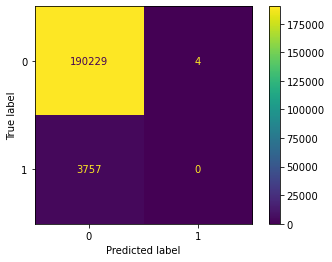

In [83]:
# all this code is identical to what we had before

# read in and join parcels and permits
path = '../weeks7-8/' # you might need to adjust the path
permits = pd.read_csv(path+'ADU_permits.csv')  # this file should be in your GitHub folder
parcels = pd.read_csv(path+'parcels.csv')
permits.dropna(subset=['Assessor Book', 'Assessor Page','Assessor Parcel'], inplace=True)
permits = permits[permits['Assessor Parcel']!='***']
permits['APN'] = (permits['Assessor Book'].astype(int).astype(str).str.zfill(4) + '-' 
                   + permits['Assessor Page'].astype(int).astype(str).str.zfill(3) + '-'
                   + permits['Assessor Parcel'].astype(int).astype(str).str.zfill(3))
permits = permits.groupby('APN').first()
parcels = parcels.groupby('APN').first()
joinedDf = parcels.join(permits, how='left')

# add dependent variable and dummies
joinedDf['hasADU'] = joinedDf['# of Accessory Dwelling Units'].apply(lambda x: 0 if pd.isnull(x) else 1)
dummies1 = pd.get_dummies(joinedDf.UseType, prefix='usetype_')  # creates a dataframe of dummies
dummies2 = pd.get_dummies(joinedDf.UseDescription, prefix='usedesc_')
joinedDf = joinedDf.join(dummies1).join(dummies2) 

# split the data and fit the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

xvars = ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON', 'usedesc__Single']
yvar = 'hasADU'
df_to_fit = joinedDf[xvars+[yvar]].dropna()
X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

lr = LogisticRegression()
lr.fit(X_train[xvars], y_train)
plot_confusion_matrix(lr, X_test[xvars], y_test)

# print the logistic regression coefficients
print(lr.coef_)

What if we just estimate this model on half the data? We can use the `sample` function in `pandas`.

The coefficients are pretty much identical. And the numbers in the confusion matrix are roughly halved (because we have half the sample).

[[-6.01193660e-04 -2.28053185e-07  1.54670571e-09  2.30747813e-08
  -1.31837624e-04  8.83746515e-08  1.18550935e-08 -6.28405382e-04
  -6.28241903e-04 -1.08654450e-05  3.79088991e-05 -1.07124978e-07]]


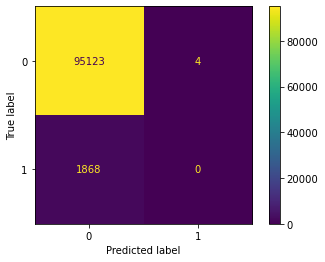

In [84]:
df_to_fit = joinedDf[xvars+[yvar]].dropna()
df_to_fit = df_to_fit.sample(frac=0.5) # take 50% sample
X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

lr = LogisticRegression()
lr.fit(X_train[xvars], y_train)
plot_confusion_matrix(lr, X_test[xvars], y_test)
print(lr.coef_)

Takeaway: we get the same output with half the data.

What about the random forests model? Let's compare the full dataset to a 50% sample.

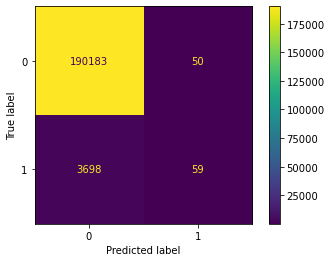

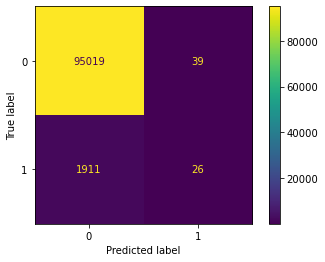

In [86]:
xvars = (dummies1.columns.tolist() + dummies2.columns.tolist() + 
            ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON' ])
yvar = 'hasADU'

df_to_fit = joinedDf[xvars+[yvar]].dropna()

for i in range(2): # do two iterations
    X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)
    rf = RandomForestClassifier(n_estimators = 10, random_state = 1)  # 10 estimators to save time
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    plot_confusion_matrix(rf, X_test, y_test)

    # before starting the second loop, do a 50% sample
    df_to_fit = df_to_fit.sample(frac=0.5) # take 50% sample
    

This isn't so bad. (Remember all of the entries in the confusion matrix should have half the observations, because we have half the sample size.)

However, a better way forward here might be to:
1. Estimate the model on a sample of the data
2. Look at the feature importances
3. Run the model on the full data, but excluding some of the variables that don't increase predictive performance (i.e., low importance)

*Tiling* is a related strategy, particularly useful for geographic data. For example, if you want to calculate nearest neighbors, you could loop over each 1km square grid cell (or census tract, or county).

## 2. Parallel processing
* Databases
* Using Python multiprocessing
* MapReduce

Even basic laptops usually come with multiple cores. Some functions, like the `scikit-learn` machine learning models, have a parameter that you can set to use more than one core (e.g. `n_jobs=-1` in `RandomForestClassifier`). 

Postgres and other databases can also make use of multiple cores to do CPU-intensive operations such as spatial joins. They also write intermediate results to disk so help with memory too (a SSD helps).

In other cases, you'll need to do the parallelization yourself. Python helps through the `multiprocessing` library. The key is to set up discrete *functions* that can then be run in parallel on different subsets of the data.

Let's recreate the example we used in the Data wrangling part of the course, to calculate the distance from every census tract to the closest food pantry.


In [87]:
from cenpy import products
import requests
import json
import geopandas as gpd
import pandas as pd


# get the census tract boundaries for LA
incomeDf = products.ACS(2017).from_place('Los Angeles, CA', level='tract')

# get the food pantries
r  = requests.get('https://controllerdata.lacity.org/resource/uztv-ve9b.json')
pantryDf = pd.DataFrame(json.loads(r.content))
pantrygdf = gpd.GeoDataFrame(
    pantryDf, geometry=gpd.points_from_xy(pantryDf.longitude, pantryDf.latitude, crs='EPSG:4326'))

# project both to state plane
pantrygdf.to_crs('EPSG:3497', inplace=True)
incomeDf.to_crs('EPSG:3497', inplace=True)

# let's slow things down by making multiple copies of the pantrygdf
pantrygdf = pd.concat([pantrygdf for i in range(10)]).reset_index()

/Users/adammb/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Matched: Los Angeles, CA to Los Angeles city within layer Incorporated Places


In [90]:
# this is the function that we had before to return the distance and id of the closest pantry to each tract
def get_closest_tract(geom):
    tract = geom.centroid 
    distances = pantrygdf.distance(tract)
    closest_pantry, min_dist = distances.idxmin(), distances.min()
    return pd.Series([closest_pantry, min_dist]) # the Series notation is because we are returning more than one column

%timeit incomeDf[['closest_pantry','dist_to_closest_pantry']] = incomeDf.geometry.apply(get_closest_tract)

3.25 s ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That was pretty fast, but again, think of a situation when we are doing this for (say) all census tracts and all grocery stores in the country.

Let's see if parallel processing can work. Don't worry about the syntax - there are lots of examples online if and when you need to use this. But I want you to understand it conceptually.

In [91]:
import time
import multiprocessing as mp
from functools import partial

# multiple lines, so we can't use %timeit
starttime = time.time()

# a complication of multiprocessing in Jupyter Notebooks is that you have to import the function from disk
# you can't define it in a cell
from get_closest_tract import *

# use 4 cores
with mp.Pool(processes=4) as pool:
    func = partial(get_closest_tract, pantrygdf)
    results = pool.map(func, incomeDf.geometry)
    
incomeDf[['closest_pantry','dist_to_closest_pantry']] = pd.concat(results, axis=1).T
print('Completed in {:.2f} seconds'.format(time.time() - starttime))

Completed in 1.80 seconds


Quite a nice speed up. Note that there is some overhead, so using 4 cores only means a ~2x speedup in this case.

What's happening? Each row of `incomeDf` is being passed to a pool. As soon as one of the 4 cores is free, it accepts the next job from the pool. Then we combine all the separate results back into a dataframe.

Multiprocessing works when *none of the jobs are dependent on each other*. It's hard to pass information between different jobs in the pool.

*MapReduce* is a related concept to parallel processing. [See the details of the algorithm here.](https://en.wikipedia.org/wiki/MapReduce) In short, there is a *map* stage (filtering and sorting), and a *reduce* stage (reducing the input data to something smaller). Each of the mapper and reducer nodes can run in parallel.

A canonical example is word counting.

![mapreduce](https://upload.wikimedia.org/wikipedia/commons/0/03/WordCountFlow.JPG)

Map Reduce is normally done in the cloud (there are specialist tools like Hadoop), but you could do it on a local machine in Python as well. Conceptually, think about what are the discrete, independent chunks that you can split your tasks into.

## 3. Outgrowing your local machine
Almost all of my data science work is run locally on my office computer. Currently, I have a 2018 Mac Mini, and my previous desktop was from 2008, so it's not like you need a lot of computing power to do most tasks. You might need a large external hard drive.

Sometimes it takes a few days to a week, running in the background. Sometimes I have to parallelize or tile, or be judicious about data types. But for me, it's often more convenient than uploading to (and paying for) a cloud service.

For some jobs, however, you will outgrow your laptop. We won't say much about other options in this course, but in general there are three options:
* Beg, steal, borrow. Can you get access to a computer in the GIS lab to run over the weekend or holidays?
* UCLA's Hoffman2 cluster. You can run pretty much any Python code as a "batch job," meaning that your job will be queued until there are resources available for it to run. [See the details here.](https://www.hoffman2.idre.ucla.edu) 
* Cloud-based Python services like [DeepNote](https://deepnote.com/education) (basic plan free for educational users) or Python Anywhere. The amount of memory and compute power varies, but generally you pay for what you use.
* More general cloud services like AWS, Google Cloud, Microsoft Azure, etc. These let you run Python and pretty much any other open-source tool, including databases.

These options are changing all the time, so keep an eye out for new firms and services that are being offered.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Start simple! Most "big" datasets can be handled on any laptop through judicious use of datatypes, profiling your code, and working on a chunk of your data at one time.</li>
  <li>A database like PostgreSQL is the next logical step, particularly if you have intensive spatial analysis needs. You can run Postgres on most computers, and hook up an external hard drive for large datasets.</li>
  <li>You will rarely need to do more than this, but the UCLA Hoffman2 cluster and cloud service providers are there if you need them.</li>
</ul>
<h3>And that's it, folks!</h3>
</div>